# Draw US EV Sales Map 

In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
import numpy as np

import seaborn as sns
from scipy.stats import ttest_ind
import geopandas as gpd
from geopandas import GeoDataFrame

%matplotlib inline

## Parameters 

In [5]:
EV_SALE_DATASET = '../Processed_Data/Ev_sales.csv'

# https://eric.clst.org/tech/usgeojson/
# https://www.weather.gov/gis/USStates
USA_SHAPEFILE = '../Raw_Data/US_Map_5m.json'

# Load Datasets
## Load the EV sales dataset

In [6]:
df = pd.read_csv(EV_SALE_DATASET,index_col=[0],nrows=51,thousands=',')
df = df.set_index("State")
df.head()

,2016,2017,2018,2019
State,,,,
California,73854,94873,153442,145020
New York,6043,10090,15752,14823
Washington,5363,7068,12650,12172
Florida,6255,6573,13705,15794
Texas,4510,5419,11764,5780


## Load the US shapefile

In [7]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
#us = gpd.read_file('./data/s_22mr22/s_22mr22.shp')
US_gpd = gpd.read_file(USA_SHAPEFILE)[['NAME', 'geometry']]\
    .rename(columns={'NAME':'States'})\
    .set_index('States')
US_gpd.head()

,geometry
States,
Alabama,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
Alaska,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
Arizona,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
Arkansas,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
California,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [8]:
print(type(US_gpd))
US_gpd.crs

<class 'geopandas.geodataframe.GeoDataFrame'>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Displaying a Map 

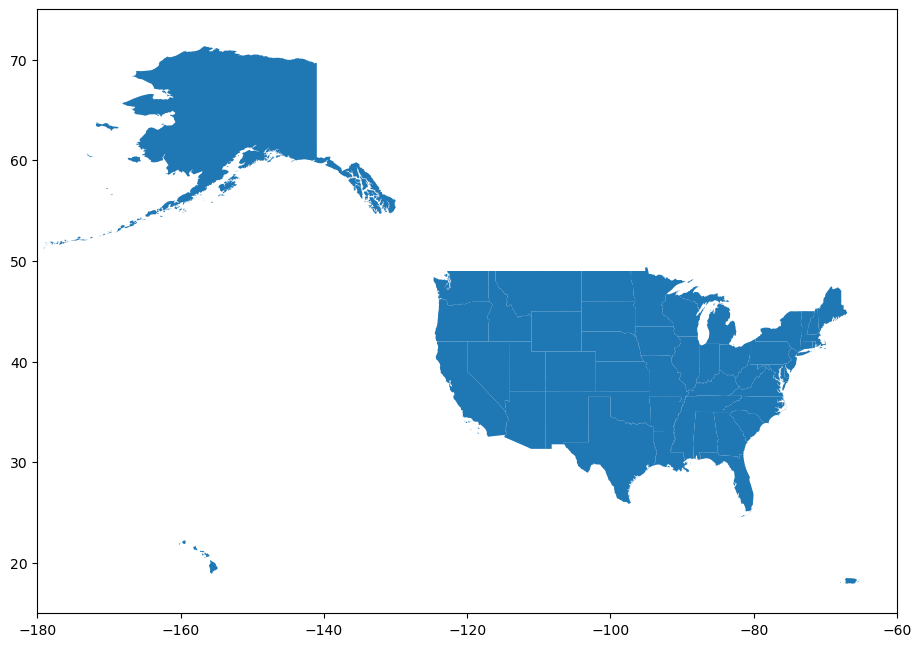

In [9]:
fig, ax = plt.subplots(figsize=(12, 8),dpi=100)
ax = US_gpd.plot(ax=ax)

plt.xlim([-180, -60])
plt.ylim([15, 75])
plt.show()

### Tighten up the view

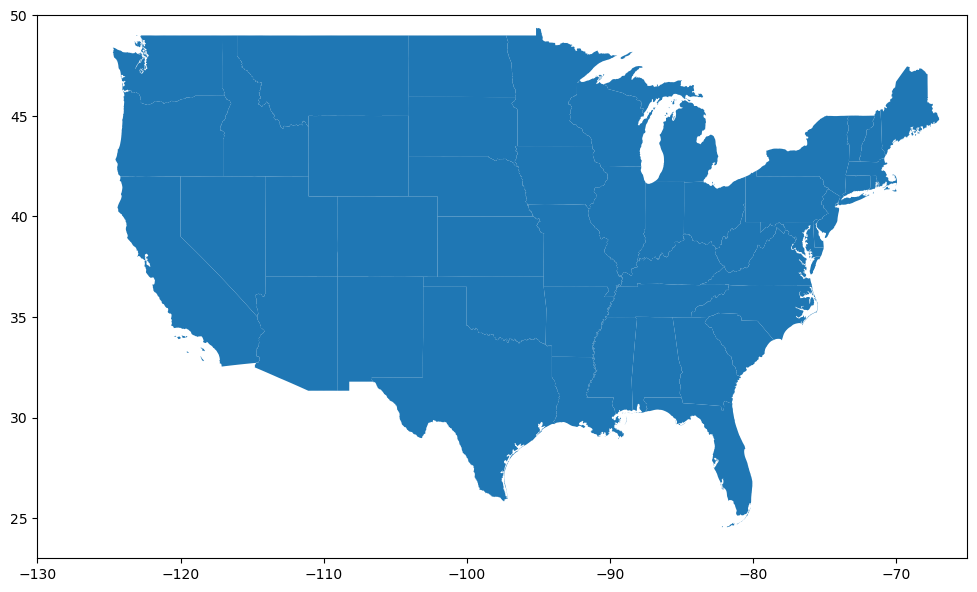

In [10]:
fig, ax = plt.subplots(figsize=(12, 8),dpi=100)
ax = US_gpd.plot(ax=ax)

plt.xlim([-130, -65])
plt.ylim([23, 50])
plt.show()

In [11]:
#us["area"] = us.area
#us.explore("area", legend=False)

# Visualising NEV sales

Add the ev sales data into the map dataframe as follows:

In [12]:
df.head(3)

,2016,2017,2018,2019
State,,,,
California,73854,94873,153442,145020
New York,6043,10090,15752,14823
Washington,5363,7068,12650,12172


In [13]:
US_Sales = pd.concat([df, US_gpd], axis = 1)
US_Sales.head()

,2016,2017,2018,2019,geometry
California,73854.0,94873.0,153442.0,145020.0,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."
New York,6043.0,10090.0,15752.0,14823.0,"MULTIPOLYGON (((-74.04086 40.70012, -74.04002 ..."
Washington,5363.0,7068.0,12650.0,12172.0,"MULTIPOLYGON (((-122.51954 48.28831, -122.5227..."
Florida,6255.0,6573.0,13705.0,15794.0,"MULTIPOLYGON (((-82.82158 27.96444, -82.82980 ..."
Texas,4510.0,5419.0,11764.0,5780.0,"MULTIPOLYGON (((-97.13436 27.89633, -97.13360 ..."


Try converting the merged dataframe into a geodataframe

In [14]:
US_Sales = GeoDataFrame(US_Sales)

devide data into main & outside

In [15]:
df_Alaska = US_Sales[US_Sales.index == 'Alaska']
df_Hawaii = US_Sales[US_Sales.index == 'Hawaii']
df_Main = US_Sales.drop(index=('Alaska'))
df_Main = df_Main.drop(index=('Hawaii'))
len(US_Sales),len(df_Main)

(52, 50)

Re-draw the graph to use the sales data as the basis for each county's colour through setup the colour map.

<AxesSubplot:>

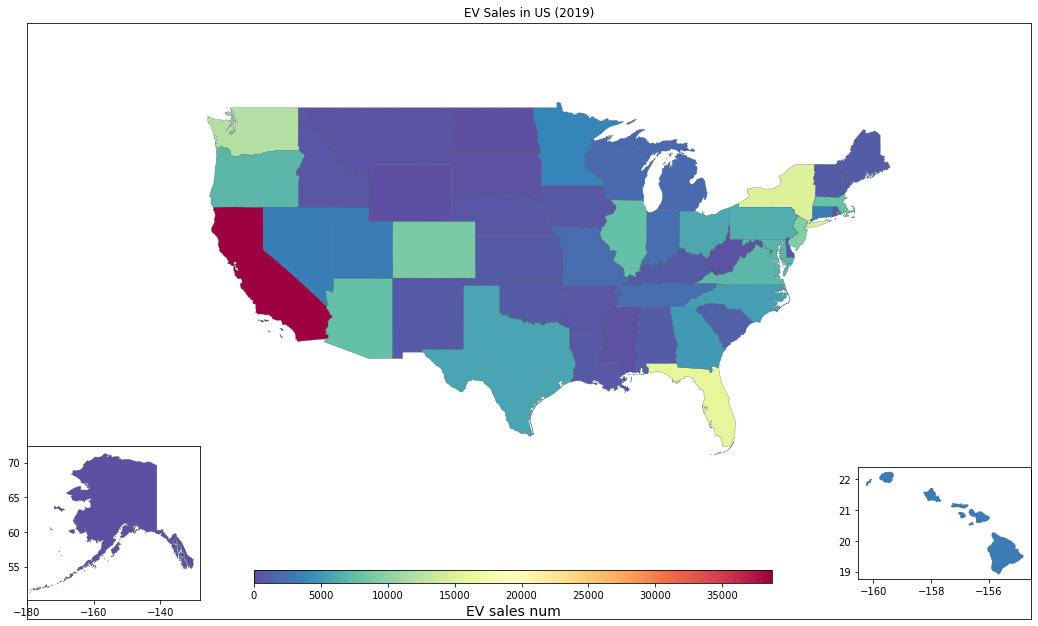

In [16]:
fig = plt.figure(figsize=[18,18])
ax = fig.add_subplot(111)

# Since California has the highest number and is 9.7 times than others, 
# we used the average of the top 5 to adjust our color range.
max_sale = US_Sales['2019'].head(5).mean()

# Setup the colour map and normalise it.
norm = matplotlib.colors.Normalize(vmin=0, vmax=max_sale)
cmap = matplotlib.cm.get_cmap('Spectral_r')

# Draw US main map
df_Main.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')

# Tighten up the view
plt.xlim([-140, -55])
plt.ylim([13, 55])

# Remove unnecessary tick marks.
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set title label.
ax.set_title('EV Sales in US (2019)')

# Add the colour bar and label it.
cax = fig.add_axes([.3, .30, .4, .01])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cb.set_label('EV sales num', fontsize=14)


# Draw Alaska Map
ax = fig.add_subplot(5,5,16)
df_Alaska.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
# Tighten up the view
plt.xlim([-180, -128])

# Draw Hawaii Map
ax = fig.add_subplot(5,5,20)
df_Hawaii.plot(column='2019', cmap=cmap, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')

In [17]:
fig.savefig('EV_Sales_in_US.png', format='png')